In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

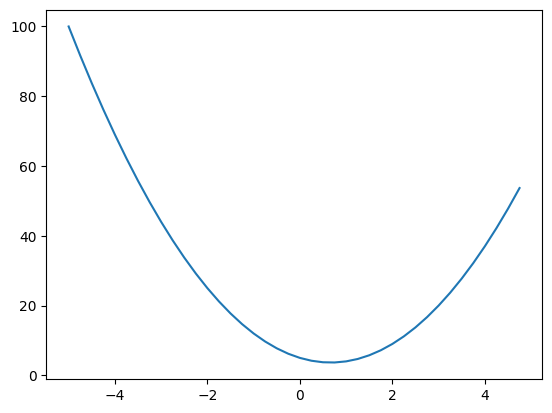

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = -3.0
(f(x+h) - f(x))/h

-22.00000039920269

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [203]:
def cast_other_value(fun):
    def inner(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return fun(self, other)
    return inner


class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    @cast_other_value
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out

    @cast_other_value
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + (-1. * other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), f'Unsupported data type {type(other)}'
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other - 1.) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [204]:
Value(2.0) / Value(4.0)

Value(data=0.5)

In [205]:
Value(2.0) ** 4

Value(data=16.0)

In [56]:
x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

x1w1 = x1*w1
x2w2 = x2*w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
# --------
e = (2*n).exp()
o = (e - 1)/(e + 1)
# --------
# or
# o = n.tanh()
print(o)

Value(data=0.7071067811865476)


In [54]:
o.backward()

In [55]:
print(
    [w2.grad, x2.grad, x1.grad, w1.grad],
    [x2w2.grad, x1w1.grad],
    [x1w1x2w2.grad, b.grad],
    [n.grad],
    [o.grad],
)

[0.0, 0.5, -1.5, 1.0] [0.5, 0.5] [0.5, 0.5] [0.5] [1.0]


In [34]:
a = Value(3.0)
b = a + a
b.backward()
print(
    [a.grad],
    [b.grad]
)

[2.0] [1.0]


In [206]:
import random
import itertools
random.seed(42)


class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, number_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(number_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self, number_input, number_outputs):
        self.neurons = [Neuron(number_input) for _ in range(number_outputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return list(itertools.chain.from_iterable([n.parameters() for n in self.neurons]))

class MLP(Module):
    def __init__(self, number_inputs, number_outputs):
        sz = [number_inputs] + number_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(number_outputs))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        return list(itertools.chain.from_iterable([l.parameters() for l in self.layers]))

In [102]:
x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.6994093620224068)

In [103]:
n.parameters()

[Value(data=0.2788535969157675),
 Value(data=-0.9499784895546661),
 Value(data=-0.4499413632617615),
 Value(data=-0.5535785237023545),
 Value(data=0.4729424283280248),
 Value(data=0.3533989748458226),
 Value(data=0.7843591354096908),
 Value(data=-0.8261223347411677),
 Value(data=-0.15615636062945915),
 Value(data=-0.9404055611238593),
 Value(data=-0.5627240503927933),
 Value(data=0.010710576206724776),
 Value(data=-0.9469280606322728),
 Value(data=-0.602324698626703),
 Value(data=0.2997688755590464),
 Value(data=0.08988296120643335),
 Value(data=-0.5591187559186066),
 Value(data=0.17853136775181744),
 Value(data=0.6188609133556533),
 Value(data=-0.987002480643878),
 Value(data=0.6116385036656158),
 Value(data=0.3962787899764537),
 Value(data=-0.31949896696401625),
 Value(data=-0.6890410003764369),
 Value(data=0.9144261444135624),
 Value(data=-0.32681090977474647),
 Value(data=-0.8145083132397042),
 Value(data=-0.806567246333072),
 Value(data=0.6949887326949196),
 Value(data=0.207452062

In [104]:
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [.5,1,1],
    [1,1,-1]
]
ys = [1,-1, -1, 1]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6994093620224068),
 Value(data=0.5026295816615511),
 Value(data=0.6931545900944501),
 Value(data=0.8755224728708613)]

In [105]:
[(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.0903547316397765),
 Value(data=2.257895659684368),
 Value(data=2.8667724659579052),
 Value(data=0.015494654760185468)]

In [106]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.230517512042234)

In [107]:
loss.backward()

In [109]:
n.layers[0].neurons[0].w[0], n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data

(Value(data=0.2788535969157675), -1.3722609374247596, 0.2788535969157675)

In [110]:
learning_rate = 0.01

for p in n.parameters():
    p.data += -learning_rate * p.grad

In [111]:
n.layers[0].neurons[0].w[0], n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data

(Value(data=0.2925762062900151), -1.3722609374247596, 0.2925762062900151)

In [216]:
n = MLP(3, [4,4,1])
EPOCHS = 100
learning_rate = 0.01

# SGD

In [258]:
for epoch in range(EPOCHS):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    n.zero_grad()
    loss.backward()

    # update
    lr = 1.0 - (1.0 - learning_rate)*epoch/EPOCHS
    for p in n.parameters():
        p.data += -lr * p.grad

    print(f'EPOCH {epoch}: loss = {loss.data}')

EPOCH 0: loss = 7.899129370534339e-06
EPOCH 1: loss = 7.895321820902387e-06
EPOCH 2: loss = 7.89155558011175e-06
EPOCH 3: loss = 7.887830535332966e-06
EPOCH 4: loss = 7.88414657512464e-06
EPOCH 5: loss = 7.880503589423223e-06
EPOCH 6: loss = 7.876901469536988e-06
EPOCH 7: loss = 7.873340108134781e-06
EPOCH 8: loss = 7.869819399240007e-06
EPOCH 9: loss = 7.866339238222578e-06
EPOCH 10: loss = 7.86289952178975e-06
EPOCH 11: loss = 7.859500147979886e-06
EPOCH 12: loss = 7.856141016152694e-06
EPOCH 13: loss = 7.85282202698463e-06
EPOCH 14: loss = 7.849543082457019e-06
EPOCH 15: loss = 7.846304085853122e-06
EPOCH 16: loss = 7.843104941749163e-06
EPOCH 17: loss = 7.839945556006856e-06
EPOCH 18: loss = 7.836825835765608e-06
EPOCH 19: loss = 7.833745689437904e-06
EPOCH 20: loss = 7.830705026701275e-06
EPOCH 21: loss = 7.827703758489443e-06
EPOCH 22: loss = 7.8247417969898e-06
EPOCH 23: loss = 7.821819055634234e-06
EPOCH 24: loss = 7.81893544909419e-06
EPOCH 25: loss = 7.816090893272043e-06
EPO

In [259]:
[n(x) for x in xs]

[Value(data=0.9983833852865436),
 Value(data=-0.9988006199181774),
 Value(data=-0.9998223163924643),
 Value(data=0.9980957918650755)]